In [5]:
import joblib

mlp = joblib.load("mlp_model.pkl")

In [6]:
from project import load_data


X_train, X_test, y_train, y_test = load_data()

alcohol
CL5    757
CL6    503
CL4    284
CL3    197
CL2     68
CL1     34
CL0     33
Name: count, dtype: int64
amphet
CL0    973
CL2    240
CL1    230
CL3    196
CL6    101
CL4     75
CL5     61
Name: count, dtype: int64
amyl
CL0    1298
CL2     236
CL1     210
CL3      91
CL4      24
CL5      14
CL6       3
Name: count, dtype: int64
benzos
CL0    999
CL3    234
CL2    229
CL4    119
CL1    116
CL6     95
CL5     84
Name: count, dtype: int64
caff
CL6    1379
CL5     271
CL4     106
CL3      59
CL0      27
CL2      24
CL1      10
Name: count, dtype: int64
cannabis
CL6    458
CL0    412
CL2    266
CL3    210
CL1    207
CL5    185
CL4    138
Name: count, dtype: int64
choc
CL6    805
CL5    679
CL4    295
CL3     53
CL0     32
CL2     10
CL1      2
Name: count, dtype: int64
coke
CL0    1035
CL2     267
CL3     257
CL1     160
CL4      98
CL5      40
CL6      19
Name: count, dtype: int64
crack
CL0    1621
CL2     109
CL1      67
CL3      59
CL5       9
CL4       9
CL6       2
Name: count, d

In [7]:
from lime.lime_tabular import LimeTabularExplainer

lime_explainer = LimeTabularExplainer(X_train.values, feature_names=X_train.columns, class_names=[0, 1], discretize_continuous=False)
lime_values = [dict(sorted(lime_explainer.explain_instance(x, mlp.predict_proba, num_features=12).as_list(), key=lambda x: x[0])) for x in X_test.values]


In [8]:
import shap

shap_explainer = shap.KernelExplainer(mlp.predict_proba, X_test)
shap_values = shap_explainer.shap_values(X_test)


Using 376 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/376 [00:00<?, ?it/s]

In [9]:
shap_values_positive = shap_values[:, :, 1]

In [10]:
import torch
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, mlp_model):
        super(MLP, self).__init__()
        self.hidden1 = nn.Linear(10, 32)
        self.hidden2 = nn.Linear(32, 16)
        self.output = nn.Linear(16, 1)  # Adjust output size based on your problem

        # Copy weights from the trained MLPClassifier
        self.hidden1.weight.data = torch.tensor(mlp_model.coefs_[0].T, dtype=torch.float32)
        self.hidden1.bias.data = torch.tensor(mlp_model.intercepts_[0], dtype=torch.float32)
        self.hidden2.weight.data = torch.tensor(mlp_model.coefs_[1].T, dtype=torch.float32)
        self.hidden2.bias.data = torch.tensor(mlp_model.intercepts_[1], dtype=torch.float32)
        self.output.weight.data = torch.tensor(mlp_model.coefs_[2].T, dtype=torch.float32)
        self.output.bias.data = torch.tensor(mlp_model.intercepts_[2], dtype=torch.float32)

    def forward(self, x):
        x = torch.sigmoid(self.hidden1(x))
        x = torch.sigmoid(self.hidden2(x))
        x = self.output(x)
        return x

# Create a PyTorch model from the scikit-learn model
torch_model = MLP(mlp)

In [11]:
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

In [13]:
from captum.attr import LRP
import numpy as np

lrp = LRP(torch_model)

attributions = lrp.attribute(X_test_tensor)
attributions = attributions.detach().cpu().numpy()


c:\Users\guillemette\anaconda3\envs\new_env_python\lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


In [14]:
lime_values_featureless = [list(val.values()) for val in lime_values]
lime_values_featureless[0]

[-0.1127246460848036,
 -0.0025968865615050183,
 -0.11644632680772204,
 -0.08037108226032569,
 -0.0843787253648767,
 -0.0297136215930073,
 -0.01656519815002527,
 -0.03656086880178745,
 0.13125725455309312,
 0.1330095658187564]

In [15]:
import importlib
import evaluation
importlib.reload(evaluation)

lime_evaluations, lime_fpr, lime_tpr, lime_roc_auc = evaluation.run_evaluations(lime_values_featureless, y_test.values.ravel())

Best Hyperparameters: {'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 300}


In [19]:
shap_evaluations, shap_fpr, shap_tpr, shap_roc_auc = evaluation.run_evaluations(shap_values_positive, y_test.values.ravel())

Best Hyperparameters: {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 200}


In [16]:
lrp_evaluations, lrp_fpr, lrp_tpr, lrp_roc_auc = evaluation.run_evaluations(attributions, y_test.values.ravel())

Best Hyperparameters: {'criterion': 'gini', 'max_depth': 4, 'max_features': 12, 'n_estimators': 300}


In [17]:
lime_evaluations

,k,Silhouette Kmeans,Silhouette Spectral,DBI Kmeans,DBI Spectral
0,2,0.631650,-0.290550,0.635326,1.124893
1,3,0.463265,-0.346222,0.807045,1.271984
2,4,0.449640,-0.356526,0.754685,1.331225
3,5,0.273402,-0.359467,1.062861,1.318305
4,6,0.277867,-0.373980,1.079494,2.271904
5,7,0.244029,-0.382067,1.191205,1.259933
6,8,0.209977,-0.360669,1.259889,1.713068


In [21]:
shap_evaluations

,k,Silhouette Kmeans,Silhouette Spectral,DBI Kmeans,DBI Spectral
0,2,0.338627,-0.010059,1.257811,0.992164
1,3,0.350056,-0.055019,1.301616,0.958223
2,4,0.297553,-0.091971,1.546867,1.059809
3,5,0.289371,-0.335061,1.558537,1.073556
4,6,0.239271,-0.338926,1.568468,1.139340
5,7,0.216251,-0.362520,1.515549,1.063116
6,8,0.210718,-0.367722,1.670669,1.162812


In [20]:
lrp_evaluations

,k,Silhouette Kmeans,Silhouette Spectral,DBI Kmeans,DBI Spectral
0,2,0.957330,-0.764898,0.329260,1.519422
1,3,0.899015,-0.757476,0.503159,1.518114
2,4,0.897734,-0.758330,0.410648,1.516590
3,5,0.875263,-0.757673,0.423619,1.517182
4,6,0.799454,-0.755240,0.430843,1.516403
5,7,0.797619,-0.742234,0.395246,2.243547
6,8,0.710622,-0.735768,0.461000,3.272236


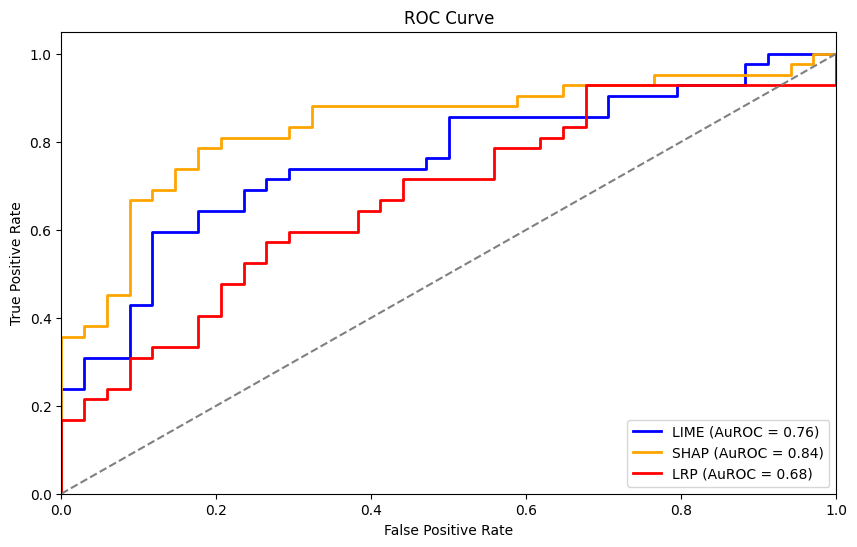

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(lime_fpr, lime_tpr, color='blue', lw=2, label=f'LIME (AuROC = {lime_roc_auc:.2f})')
plt.plot(shap_fpr, shap_tpr, color='orange', lw=2, label=f'SHAP (AuROC = {shap_roc_auc:.2f})')
plt.plot(lrp_fpr, lrp_tpr, color='red', lw=2, label=f'LRP (AuROC = {lrp_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig("ROC")
plt.show()

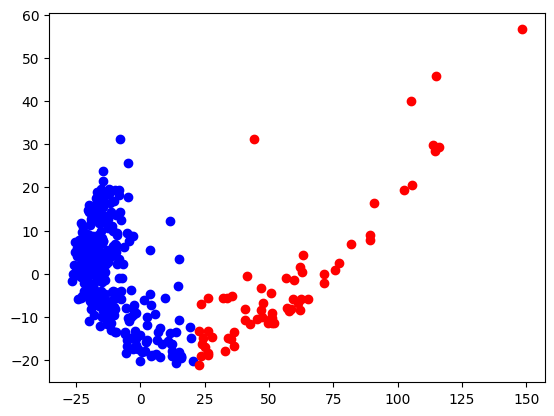

In [23]:

from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.decomposition import PCA

scaled_values = StandardScaler().fit_transform(lime_values_featureless)
pairwise_distances = squareform(pdist(scaled_values, "euclidean"))
cluster_evaluations = []

kmeans = KMeans(n_clusters=2).fit(pairwise_distances)
spectral_clusters = SpectralClustering(n_clusters=2, affinity="precomputed").fit(pairwise_distances)

pca = PCA(2)
#Transform the data
df = pca.fit_transform(pairwise_distances)
kmeans = KMeans(n_clusters= 2)
label = kmeans.fit_predict(df)
#filter rows of original data
filtered_label0 = df[label == 0]
filtered_label1 = df[label == 1]
#plotting the results
plt.scatter(filtered_label0[:,0] , filtered_label0[:,1], color='blue')
plt.scatter(filtered_label1[:,0] , filtered_label1[:,1], color='red')

plt.show()


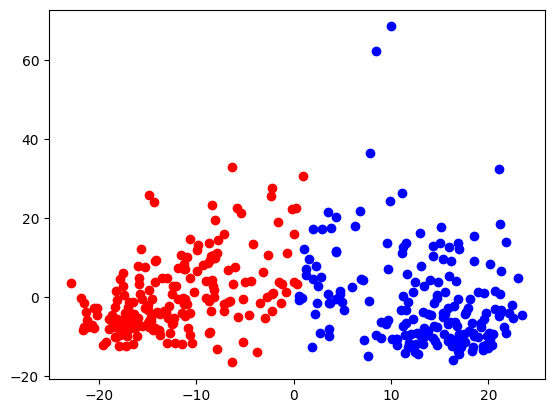

In [24]:
scaled_values = StandardScaler().fit_transform(shap_values_positive)
pairwise_distances = squareform(pdist(scaled_values, "euclidean"))
cluster_evaluations = []

kmeans = KMeans(n_clusters=2).fit(pairwise_distances)
spectral_clusters = SpectralClustering(n_clusters=2, affinity="precomputed").fit(pairwise_distances)

#Transform the data
df = pca.fit_transform(pairwise_distances)
label = kmeans.fit_predict(df)
#filter rows of original data
filtered_label0 = df[label == 0]
filtered_label1 = df[label == 1]
#plotting the results
plt.scatter(filtered_label0[:,0] , filtered_label0[:,1], color='blue')
plt.scatter(filtered_label1[:,0] , filtered_label1[:,1], color='red')

plt.show()


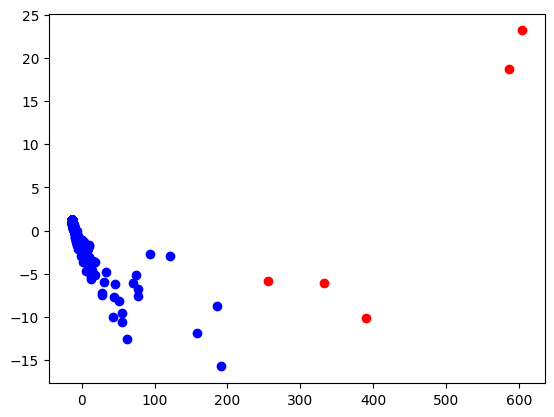

In [25]:
scaled_values = StandardScaler().fit_transform(attributions)
pairwise_distances = squareform(pdist(scaled_values, "euclidean"))
cluster_evaluations = []

kmeans = KMeans(n_clusters=2).fit(pairwise_distances)
spectral_clusters = SpectralClustering(n_clusters=2, affinity="precomputed").fit(pairwise_distances)

#Transform the data
df = pca.fit_transform(pairwise_distances)
label = kmeans.fit_predict(df)
#filter rows of original data
filtered_label0 = df[label == 0]
filtered_label1 = df[label == 1]
#plotting the results
plt.scatter(filtered_label0[:,0] , filtered_label0[:,1], color='blue')
plt.scatter(filtered_label1[:,0] , filtered_label1[:,1], color='red')

plt.show()


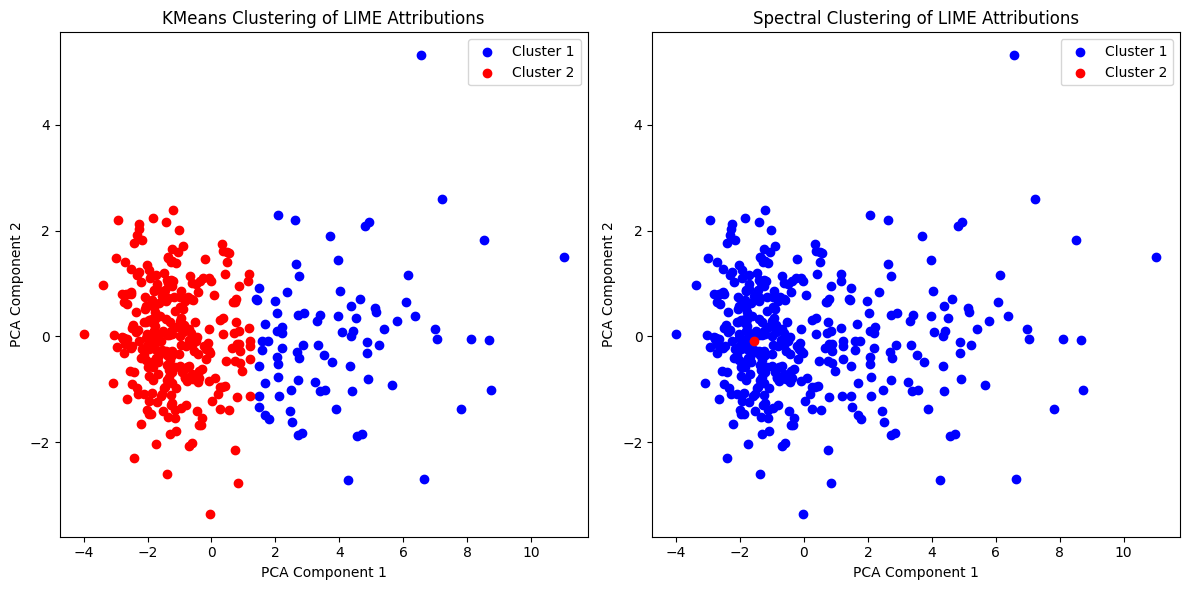

Silhouette Score (KMeans): 0.460
Silhouette Score (Spectral): -0.291
Davies-Bouldin Index (KMeans): 0.933
Davies-Bouldin Index (Spectral): 1.125


In [30]:
#Cluster TRIAL
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.spatial.distance import pdist, squareform

scaled_values = StandardScaler().fit_transform(lime_values_featureless)
pairwise_distances = squareform(pdist(scaled_values, "euclidean"))
kmeans = KMeans(n_clusters=2, random_state=42).fit(scaled_values)
kmeans_labels = kmeans.labels_
spectral_clusters = SpectralClustering(n_clusters=2, affinity="precomputed", random_state=42).fit(pairwise_distances)
spectral_labels = spectral_clusters.labels_

# PCA for visualization just to see if there was another way to look at clusters but seems similar 
pca = PCA(2)
df = pca.fit_transform(scaled_values)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
filtered_label0 = df[kmeans_labels == 0]
filtered_label1 = df[kmeans_labels == 1]
plt.scatter(filtered_label0[:, 0], filtered_label0[:, 1], color='blue', label='Cluster 1')
plt.scatter(filtered_label1[:, 0], filtered_label1[:, 1], color='red', label='Cluster 2')
plt.title('KMeans Clustering of LIME Attributions')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()

plt.subplot(1, 2, 2)
filtered_label0 = df[spectral_labels == 0]
filtered_label1 = df[spectral_labels == 1]
plt.scatter(filtered_label0[:, 0], filtered_label0[:, 1], color='blue', label='Cluster 1')
plt.scatter(filtered_label1[:, 0], filtered_label1[:, 1], color='red', label='Cluster 2')
plt.title('Spectral Clustering of LIME Attributions')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()

plt.tight_layout()
plt.show()

silhouette_kmeans = silhouette_score(scaled_values, kmeans_labels)
silhouette_spectral = silhouette_score(pairwise_distances, spectral_labels)
dbi_kmeans = davies_bouldin_score(scaled_values, kmeans_labels)
dbi_spectral = davies_bouldin_score(pairwise_distances, spectral_labels)
print(f"Silhouette Score (kmeans): {silhouette_kmeans:.3f}")
print(f"Silhouette Score (spectral): {silhouette_spectral:.3f}")
print(f"Davies-Bouldin Index (kmeans): {dbi_kmeans:.3f}")
print(f"Davies-Bouldin Index (spectral): {dbi_spectral:.3f}")